In [1]:
import numpy as np
from scipy.linalg import norm
from sympy import Symbol, Matrix, diag, eye, cos, sin, exp, pi, lambdify
from sympy.physics.quantum import Dagger, TensorProduct
import matplotlib.pyplot as plt

j = np.complex(0, 1)

pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -j], [j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

I = np.array([[1, 0], [0, 1]])

H_matrix = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])

CNOT_matrix = np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,0,1],
                        [0,0,1,0]])

CNOT_tensor = np.reshape(CNOT_matrix, (2,2,2,2))

class Reg: 
    def __init__(self, n):
        self.n = n
        self.psi = np.zeros((2,) * n) 
        self.psi[(0,) * n] = 1        

#def I(i, reg):
#    reg.psi = np.tensordot(I, reg.psi, (1, i)) 
#    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def H(i, reg):
    reg.psi = np.tensordot(H_matrix, reg.psi, (1, i)) 
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Z(i, reg):
    reg.psi = np.tensordot(pauli_z, reg.psi, (1, i)) 
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Ry(i, reg, angle="theta", angle_value=None):
    angle = Symbol(angle, real=True)
    ry = Matrix([[cos(angle/2), -sin(angle/2)], [sin(angle/2), cos(angle/2)]])
    if angle_value is None:
        reg.psi = np.tensordot(ry, reg.psi, (1, i))
    else:
        reg.psi = np.tensordot(ry.subs(angle, angle_value), reg.psi, (1, i))
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Rx(i, reg, angle="theta", angle_value=None):
    angle = Symbol(angle, real=True)
    j = np.complex(0, 1)
    rx = Matrix([[cos(angle/2), -j*sin(angle/2)], [-j*sin(angle/2), cos(angle/2)]])
    if angle_value is None:
        reg.psi = np.tensordot(rx, reg.psi, (1, i))
    else:
        reg.psi = np.tensordot(rx.subs(angle, angle_value), reg.psi, (1, i))
    reg.psi = np.moveaxis(reg.psi, 0, i)
    
def Rz(i, reg, angle="theta", angle_value=None):
    angle = Symbol(angle, real=True)
    j = np.complex(0, 1)
    #rz = Matrix([[exp((-j*theta/2)), 0], [0, exp((j*theta/2))]])
    rz = Matrix([[cos(angle/2) -j*sin(angle/2), 0], [0, cos(angle/2) +j*sin(angle/2)]])
    if angle_value is None:
        reg.psi = np.tensordot(rz, reg.psi, (1, i))
    else:
        reg.psi = np.tensordot(rz.subs(angle, angle_value), reg.psi, (1, i))
    reg.psi = np.moveaxis(reg.psi, 0, i)

def CNOT(control, target, reg):
    reg.psi = np.tensordot(CNOT_tensor, reg.psi, ((2,3), (control, target))) 
    reg.psi = np.moveaxis(reg.psi, (0, 1), (control, target))   

def measure(i, reg): 
    projectors = [np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])] 
    
    def project(i, j, reg): 
        projected = np.tensordot(projectors[j], reg.psi, (1, i))
        return np.moveaxis(projected, 0, i)
    
    projected = project(i, 0, reg) 
    norm_projected = norm(projected.flatten()) 
    if np.random.random() < norm_projected ** 2: 
        reg.psi = projected/norm_projected
        return 0
    else:
        projected = project(i, 1, reg)
        reg.psi = projected/norm(projected)
        return 1

In [2]:
reg = Reg(1)
state_initial = reg.psi.flatten()
print(reg.psi.flatten())

[1. 0.]


#### hamiltonian = pauli_z

In [3]:
Ry(0, reg)
ansatz = reg.psi.flatten()
print(reg.psi.flatten())

[1.0*cos(theta/2) 1.0*sin(theta/2)]


In [4]:
Z(0, reg)
print(reg.psi.flatten())

[1.0*cos(theta/2) -1.0*sin(theta/2)]


In [5]:
expected = np.dot(ansatz, reg.psi.flatten())
expected

-1.0*sin(theta/2)**2 + 1.0*cos(theta/2)**2

Minimal Energy:  -1.0


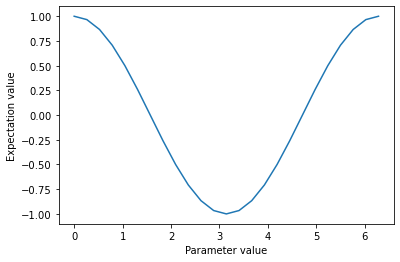

In [6]:
theta = Symbol("theta", real=True)
theta_range = np.linspace(0.0, 2 * np.pi, 25)
f = lambdify(theta, expected, "numpy")
data = f(theta_range)
print("Minimal Energy: ", min(data))

plt.xlabel("Parameter value")
plt.ylabel("Expectation value")
plt.plot(theta_range, data)
plt.show()

#### hamiltonian = 2*pauli_z + pauli_x + I

Minimal Energy:  -1.2320508075688779


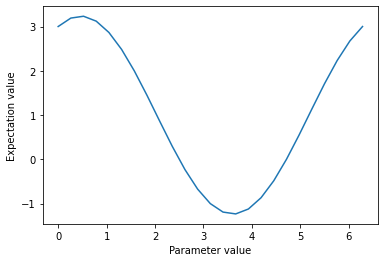

In [7]:
reg_z = Reg(1)
reg_x = Reg(1)
reg_I = Reg(1)
state_initial = reg_z.psi.flatten()

Ry(0, reg_z)
Ry(0, reg_x)
Ry(0, reg_I)

ansatz_z = reg_z.psi.flatten()
Z(0, reg_z)

Ry(0, reg_x, angle_value=-np.pi/2)
ansatz_x = reg_x.psi.flatten()
Z(0, reg_x)

#I(0, reg_I)
#ansatz_z = reg_z.psi.flatten()

expected = 2 * np.dot(ansatz_z, reg_z.psi.flatten()) + np.dot(ansatz_x, reg_x.psi.flatten()) + np.dot(ansatz_z, reg_I.psi.flatten())

theta = Symbol("theta", real=True)
theta_range = np.linspace(0.0, 2 * np.pi, 25)
f = lambdify(theta, expected, "numpy")
data = f(theta_range)
print("Minimal Energy: ", min(data))

plt.xlabel("Parameter value")
plt.ylabel("Expectation value")
plt.plot(theta_range, data)
plt.show()

#### hamiltonian = 1/2 IxI + 1/2 ZxZ - 1/2 YxY - 1/2 XxX

$1/2 IxI + 1/2 ZxZ$

In [8]:
reg_z = Reg(2)

H(0, reg_z)
CNOT(0, 1, reg_z)
Rx(0, reg_z)

ansatz_z = reg_z.psi.flatten()
Z(0, reg_z)
Z(1, reg_z)

expected_z = 1/2 * np.dot(ansatz_z.conjugate(), reg_z.psi.flatten())
expected_I = 1/2 * np.dot(ansatz_z.conjugate(), ansatz_z)

In [9]:
expected_z

-0.5*sin(theta/2)**2 + 0.5*cos(theta/2)**2

In [10]:
expected_I

0.5*sin(theta/2)**2 + 0.5*cos(theta/2)**2

$- 1/2 XxX$

In [11]:
reg_x = Reg(2)

H(0, reg_x)
CNOT(0, 1, reg_x)
Rx(0, reg_x)

# ansatz_x for H_x | rotate -pi/2 over Y axis
Ry(0, reg_x, angle_value=-np.pi/2)
Ry(1, reg_x, angle_value=-np.pi/2)
ansatz_x = reg_x.psi.flatten()
Z(0, reg_x)
Z(1, reg_x)

expected_x = -1/2 * np.dot(ansatz_x.conjugate(), reg_x.psi.flatten())

In [12]:
expected_x

-1.0*(-0.707106781186547*I*sin(theta/2) + 0.707106781186547*cos(theta/2))*(0.707106781186547*I*sin(theta/2) + 0.707106781186547*cos(theta/2)) + 1.23259516440783e-32*sin(theta/2)**2

$- 1/2 YxY$

In [13]:
reg_y = Reg(2)

H(0, reg_y)
CNOT(0, 1, reg_y)
Rx(0, reg_y)

# ansatz_y for H_y | rotate pi/2 over X axis
Rx(0, reg_y, angle_value=np.pi/2)
Rx(1, reg_y, angle_value=np.pi/2)
ansatz_y = reg_y.psi.flatten()
Z(0, reg_y)
Z(1, reg_y)

expected_y = -1/2 * np.dot(ansatz_y.conjugate(), reg_y.psi.flatten())

In [14]:
expected_y

-1.0*(-0.707106781186547*I*(-0.5*I*sin(theta/2) - 0.5*I*cos(theta/2)) - 0.353553390593274*sin(theta/2) + 0.353553390593274*cos(theta/2))*(0.707106781186547*I*(0.5*I*sin(theta/2) + 0.5*I*cos(theta/2)) - 0.353553390593274*sin(theta/2) + 0.353553390593274*cos(theta/2)) - 0.5*(I*(-0.5*sin(theta/2) + 0.5*cos(theta/2)) + 0.5*I*sin(theta/2) + 0.5*I*cos(theta/2))**2

Minimal Energy:  (-0.9994965423831845+0j)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


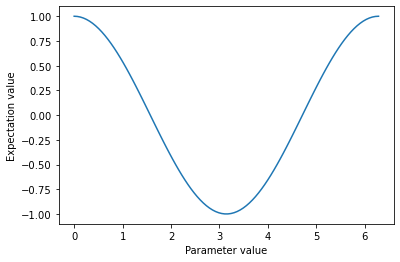

In [15]:
expected = expected_I + expected_z + expected_x + expected_y
theta_range = np.linspace(0.0, 2 * np.pi, 100)
f = lambdify(theta, expected, "numpy")
data = f(theta_range)
print("Minimal Energy: ", min(data))

plt.xlabel("Parameter value")
plt.ylabel("Expectation value")
plt.plot(theta_range, data)
plt.show()